# MiniTuring (p46)

<font size="+1" color="GREEN">**The ladder of causation**</font>

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

Authors: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

**This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 1 page 046**

In [1]:
from IPython.display import display, Math, Latex,HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os

> In order for a prisoner to be executed, a certain chain of events must take place. First, the court gives the execution order to the captain. Then, the captain gives the signal to the firing squad (two soldiers A and B) to shoot the prisoner. Finally, the soldiers obey the commandment and shoot at the prisoner.

### We create the causal diagram:
The corresponding causal diagram is the following:

In [2]:
mtt = gum.fastBN("court order->captain->soldier A->death<-soldier B<-captain")
mtt

(pyAgrum.BayesNet<double>@0x108964400) BN{nodes: 5, arcs: 5, domainSize: 32, dim: 11, mem: 176o}

In [3]:
# filling the CPTs
def smallPertubation(cpt,epsilon=0.0001):
    cpt.fillWith(cpt.translate(epsilon).normalizeAsCPT())
    
mtt.cpt("court order")[:] = [0.5, 0.5]

# The captain will give the signal only if the court gives the order.
mtt.cpt("captain")[{"court order":0}] = [1,0] 
mtt.cpt("captain")[{"court order":1}] = [0,1] 

# The soldiers only fire if the captain gives them the signal.
mtt.cpt("soldier A")[{"captain":0}] = [1, 0] # c=0
mtt.cpt("soldier A")[{"captain":1}] = [0, 1] # c=1
smallPertubation(mtt.cpt("soldier A"))

mtt.cpt("soldier B")[{"captain":0}] = [1, 0] # c=0
mtt.cpt("soldier B")[{"captain":1}] = [0, 1] # c=1
smallPertubation(mtt.cpt("soldier B"))

# It only takes one of the two soldiers to shoot for the prisoner to die.
mtt.cpt("death")[{"soldier A":0,"soldier B":0}] = [1, 0] # a=0,b=0
mtt.cpt("death")[{"soldier A":0,"soldier B":1}] = [0, 1] # a=0,b=1
mtt.cpt("death")[{"soldier A":1,"soldier B":0}] = [0, 1] # a=1,b=0
mtt.cpt("death")[{"soldier A":1,"soldier B":1}] = [0, 1] # a=1,b=1
smallPertubation(mtt.cpt("death"))

In [4]:
gnb.sideBySide(mtt,
               mtt.cpt("court order"),
               mtt.cpt("captain"),
               mtt.cpt("soldier A"),
               mtt.cpt("soldier B"),
               mtt.cpt("death"),
               captions=["the BN","the marginal for $court order$","the CPT for $captain$","the CPT for $soldier A$","the CPT for $soldier B$","the CPT for $death$"])

In [5]:
#gum.saveBN(mtt,os.path.join("out","MiniTuringTest.o3prm"))

## 1- Answering observational queries (rung one of the ladder of causation) :
> Consists of finding variables that are associated by collecting and analyzing raw data. It allows us to answer queries based on passive observation of data <b> If I observe variable $ X $, what can I say about variable $ Y $? (i.e $ P (Y \mid X) $) </b>

### If the prisoner is dead, does that mean the court order was given?

i.e. We are interested in distribution: $$P(court order \mid death = 1)$$

In [6]:
# inference engine : LazyPropagation
ie = gum.LazyPropagation(mtt)

# Knowing that death = 1
ie.setEvidence({'death':1})
ie.makeInference()
gnb.sideBySide(ie.posterior("court order"),gnb.getInference(mtt,evs={'death':1}),
              captions=["$P(court order|death=1)","Complete inference with evidence={deah:1}"])

If the prisoner is dead, this means that both soldiers fired, the captain gave the signal to the firing squad and the court ordered the execution.

### Suppose we find out that A fired. What does that tell us about B?

i.e. We are interested in distribution:
 $$P(soldierB \mid soldierA = 1)$$

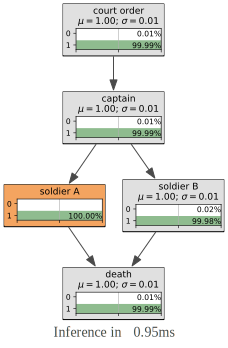

In [7]:
gnb.showInference(mtt,evs={'soldier A':1})

Following the diagram, we can say that B fired too since A wouldn't have fired if the captain didn't give the signal.

## 2- Answering interventional queries (rung two of the ladder of causation) :
> Consists of predicting the effect of a deliberate intervention <b> What would $ X $  be, if I do $ Y $? (i.e. $P(X \mid do(Y))$) </b> Interventional queries can not be answered using only passively collected data.

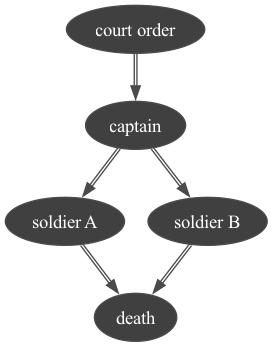

In [8]:
mttModele = csl.CausalModel(mtt)
gum.config.push()
gum.config['notebook','graph_format']='png'
gnb.show(mttModele)
gum.config.pop()

### What if Soldier A decides on his own initiative to fire, without waiting for the captain’s command? Will the prisoner be dead or alive?

In [9]:

# We do(soldier A = 1) (a deliberate intervention)
cslnb.showCausalImpact(mttModele,"death",doing="soldier A",values={"soldier A":1})

Even if the captain didn't give the command to the firing squad, the prisoner still died we soldier A decided to shoot him. 
 <br><br>

> Subset {captain} meets the back-door criterion relative to (soldier A, death) because:
* 1- no node in {captain} is a descendant of "soldier A"
* 2- {captain} blocks every path between "soldier A" and "death" that contains an arrow into "death"

> So {captain} satisfies the back-door criterion relative to (soldier A, death), the causal effect of "soldier A" over "death" is given by the formula $$P(death ∣ do(soldierA = 1)) = \sum_{captain}{P(death ∣ captain,soldierA).P(captain)}$$


### What if Soldier A decides on his own initiative to fire, without waiting for the captain’s command? What does that tell us about Soldier B?

In [10]:
# We do(soldier A = 1) (a deliberate intervention)
cslnb.showCausalImpact(mttModele,on="soldier B",doing="soldier A", values={"soldier A":1})

> A’s spontaneous decision shouldn't affect variables in the model that are not descendants of A. If we see that A shot, we conclude that B shot too (he wouldn't have shot without the captain's order). But if we make A shoot spontaneously without waiting for the captain's order, we have no information about B. This is the difference between seeing and doing.


### What if the captain decides on his own initiative to give the firing order, without waiting for the court order’s command?

In [11]:
mttModele = csl.CausalModel(mtt)
# We do(soldier A = 1) (a deliberate intervention)
cslnb.showCausalImpact(mttModele,"death",doing="captain",values={"captain":1})

> Subset {soldier A, soldier B} meets the front-door criterion relative to (captain, death) because:
* 1- {soldier A, soldier B} intercepts all directed paths from "captain" to "death"
* 2- There is no back-door path from "captain" to {soldier A, soldier B}.
* 3- All back-door paths from {soldier A, soldier B} to "death" are blocked by "captain."

## 3- Answering counterfactual queries (rung three of the ladder of causation) :
> Consists of reasoning about hypothetical situations <b>What would have happened if?</b>

### Suppose the prisoner is lying dead on the ground. From this, we can conclude (using level one) that A shot, B shot, the captain gave the signal, and the court gave the order. But what if A had decided not to shoot? Would the prisoner be alive?

To answer this question we need to compare the real world where the prisoner is lying dead on the ground, A shot, B shot, the captain gave the signal to the firing squad and the court gave the order : 
$$death = 1 \mid soldier A = 1 \mid soldier B = 1 \mid captain=1 \mid court order = 1$$
With a counterfactual world where "$soldier A = 0$", and where the arrow leading into A is erased (since he decided on his own not to shoot we emancipate it from the effect of the captain).

In [12]:
mttCounterfactual = gum.BayesNet(mtt)

# The court did give the order
mttCounterfactual.cpt("court order")[:] = [0, 1]


# Soldier A decides not to shoot
mttCounterfactual.cpt("soldier A")[0,:] = [1, 0] # c=0
mttCounterfactual.cpt("soldier A")[1,:] = [1, 0] # c=1


# We emancipate soldier A
mttCounterfactual.eraseArc("captain","soldier A")

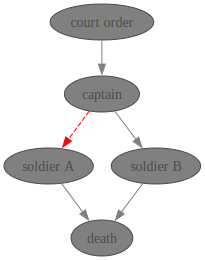

In [13]:
gnb.showBNDiff(mtt, mttCounterfactual, size='4')

In [14]:
gnb.sideBySide(mttCounterfactual,
               mttCounterfactual.cpt("court order"),
               mttCounterfactual.cpt("captain"),
               mttCounterfactual.cpt("soldier A"),
               mttCounterfactual.cpt("soldier B"),
               mttCounterfactual.cpt("death"),
               captions=["the BN","the marginal for $court order$","the CPT for $captain$","the CPT for $soldier A$","the CPT for $soldier B$","the CPT for $death$"])

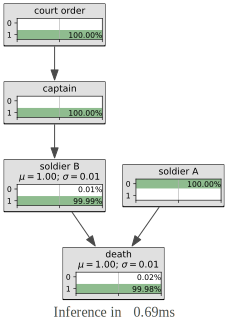

In [15]:
gnb.showInference(mttCounterfactual)

 Even if A decides not to shoot in the counterfactual world, the court did give the order to the captain who gave the signal to the firing squad including A who decided not to shoot, however, B shot and killed the prisoner.

Mathematically, this counterfactual is the following conditional probability:
$$P(death^* \mid soldier A^*=0,soldier A=1, captain=1,court order=1,death=1)$$
where variables with an ∗ are unobserved (and unobservable) variables that live in the counterfactual world, while variables without ∗ are observable.